In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [42]:
class LSTMCell(tf.keras.layers.AbstractRNNCell):
    """
    Custom LSTM cell implementation
    """
    
    def __init__(self, input_length, hidden_length):
        """
        Initializes the LSTM cell with input and hidden dimensions
        
        :param input_length: Length of the input vector
        :param hidden_length: Length of the hidden state vector
        """
        super(LSTMCell, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length

        # forget gate components
        self.linear_forget_w1 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_forget_r1 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # input gate components
        self.linear_gate_w2 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r2 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # cell memory components
        self.linear_gate_w3 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r3 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # out gate components
        self.linear_gate_w4 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r4 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        self.tanh = tf.keras.layers.Activation('tanh')

    @property
    def state_size(self):
        """
        Returns the size of the LSTM cell state
        """
        return self.hidden_length, self.hidden_length
    
    @tf.function
    def call(self, inputs, states):
        """
        Performs the forward pass through the LSTM cell
        
        :param inputs: Input tensor
        :param states: Tuple containing the previous hidden state and cell state
        """
        
        h, c = states

        # forget gate
        f = self.sigmoid(self.linear_forget_w1(inputs) + self.linear_forget_r1(h))

        # input gate
        i = self.sigmoid(self.linear_gate_w2(inputs) + self.linear_gate_r2(h))

        # cell memory
        g = self.tanh(self.linear_gate_w3(inputs) + self.linear_gate_r3(h))
        c_next = f * c + i * g

        # output gate
        o = self.sigmoid(self.linear_gate_w4(inputs) + self.linear_gate_r4(h))

        # next hidden state
        h_next = o * self.tanh(c_next)

        return h_next, [h_next, c_next]


In [43]:
class RNNModel(tf.keras.Model):
    def __init__(self, sequence_length, hidden_length, cumsum):
        super().__init__()
        
        self.cell = LSTMCell(input_length=sequence_length, hidden_length=hidden_length)
        
        self.rnn_layer = tf.keras.layers.RNN(self.cell, return_sequences=False, unroll=True)
        
        self.output_layer = tf.keras.layers.Dense(1)

        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    @tf.function
    def call(self, sequence, training=False):
        x = self.rnn_layer(sequence)
        x = self.output_layer(x)
        return x

    
    @tf.function
    def train_step(self, data):
        """
        Standard train_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        with tf.GradientTape() as tape:
            output = self.call(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        Standard test_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        output = self.call(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

In [51]:
def create_dataset(sequence_length):
    X_train = tf.cast(np.random.randint(0, 10, (1024, sequence_length)), tf.float32)
    X_train = tf.expand_dims(X_train, axis=-1)
    y_train = tf.reduce_sum(X_train[:, :, 0:2], axis=1)  # Addition der ersten beiden Zahlen in jeder Sequenz
    y_train = tf.cast(y_train, tf.float32)

    X_val = tf.cast(np.random.randint(0, 10, (512, sequence_length)), tf.float32)
    X_val = tf.expand_dims(X_val, axis=-1)
    y_val = tf.reduce_sum(X_val[:, :, 0:2], axis=1)  # Addition der ersten beiden Zahlen in jeder Sequenz
    y_val = tf.cast(y_val, tf.float32)
    
    return X_train, y_train, X_val, y_val

Training für Sequenzlänge: 5
Training für Sequenzlänge: 10
Training für Sequenzlänge: 15
Training für Sequenzlänge: 20
Training für Sequenzlänge: 25
Training für Sequenzlänge: 30


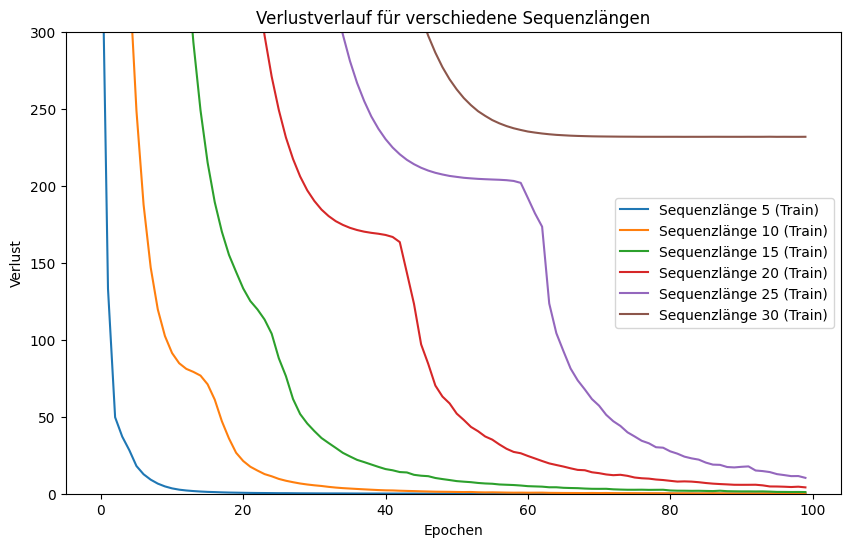

0.010430577211081982


In [67]:
def train_and_plot_loss(sequence_lengths):
    histories = {}  # Ein Dictionary zum Speichern der Verlaufshistorien
    
    for seq_length in sequence_lengths:
        print(f"Training für Sequenzlänge: {seq_length}")
        
        # Erstellen des Datensets für die aktuelle Sequenzlänge
        X_train, y_train, X_val, y_val = create_dataset(seq_length)
        
        # Modell erstellen
        model = RNNModel(sequence_length=seq_length, hidden_length=128, cumsum=False)
        
        # Modell kompilieren
        model.compile(optimizer='adam', loss='mse')
        
        # Modell trainieren
        history = model.fit(X_train, y_train, 
                            epochs=100, 
                            batch_size=32, 
                            validation_data=(X_val, y_val),
                            verbose=0)  # Verbosity auf 0 setzen, um den Trainingsfortschritt nicht auszugeben
        
        histories[seq_length] = history  # Verlaufshistorie für die aktuelle Sequenzlänge speichern
    
    # Plotten des Verlustverlaufs für jede Sequenzlänge
    plt.figure(figsize=(10, 6))
    for seq_length, history in histories.items():
        plt.plot(history.history['loss'], label=f"Sequenzlänge {seq_length} (Train)")
        # plt.plot(history.history['val_loss'], label=f"Sequenzlänge {seq_length} (Val)")

    plt.title('Verlustverlauf für verschiedene Sequenzlängen')
    plt.xlabel('Epochen')
    plt.ylabel('Verlust')
    plt.legend()
    plt.ylim(0,300)
    plt.show()
    
    return histories[sequence_lengths[0]]  # Rückgabe der Verlaufshistorie für die erste Sequenzlänge

# Trainieren und Plotten des Verlustverlaufs für Sequenzlängen 3, 10 und 20
history = train_and_plot_loss(sequence_lengths=[5,10,15,20,25,30])

print(history.history['loss'][-1])

In [58]:
import matplotlib.pyplot as plt

def plot_loss(history):
    """
    Plottet den Trainings- und Validierungsverlust über die Epochen.
    
    :param history: Das History-Objekt, das von der fit-Methode zurückgegeben wird.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(train_loss) + 1)
    
    plt.plot(epochs, train_loss, 'r', label='Trainingsverlust')
    plt.plot(epochs, val_loss, 'b', label='Validierungsverlust')
    plt.title('Trainings- und Validierungsverlust')
    plt.xlabel('Epochen')
    plt.ylabel('Verlust')
    plt.legend()
    plt.ylim(0,3000)
    plt.show()


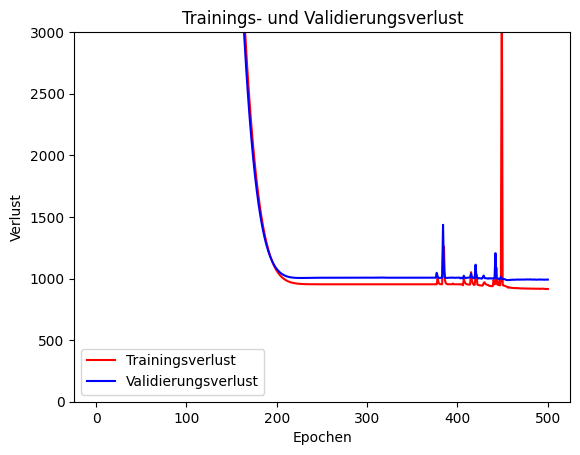

In [59]:
plot_loss(history)